In [1]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cv2
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# Função que carrega os dados
def load_data_with_pairs(folder, csv_file_path, csv_pairs_path, type):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return [], [], [], [], [], [], [], []

    # Abre o arquivo .csv com os dados e o arquivo com os pares (original e contra-lateral)
    df = pd.read_csv(csv_file_path)
    df_pairs = pd.read_csv(csv_pairs_path)

    patient_ids = []

    images_by_group = {}
    labels_by_group = {}
    mask_by_group = {}
    
    ignored_patients = ['sub-02A13', 'sub-03C08']

    current_patient_id = None
    for _, row in df.iterrows():
        patient_id = row['Nome_P']
        patch_id = row['numeracao']
        label = int(row['label'])

        if patient_id in ignored_patients:
            continue
        
        if patient_id != current_patient_id:
            current_patient_id = patient_id
            labels_by_group[patient_id] = {}

        labels_by_group[patient_id][patch_id] = label

    for _, row in tqdm(df.iterrows(), desc="Carregamento de arquivos NIfTI..."):
        patient_id = row['Nome_P']
        patch_id = row['numeracao']

        if patient_id in ignored_patients:
            continue
        
        if patient_id not in images_by_group:
            images_by_group[patient_id] = {}
        if patient_id not in mask_by_group:
            mask_by_group[patient_id] = {}
        
        image_file = f'{patient_id}_{patch_id}_recorte_{type}.nii.gz'
        mask_file = f'{patient_id}_{patch_id}_mascara_{type}.nii.gz'
        try:
            img_path = os.path.join(folder, image_file)
            image_data = nib.load(img_path).get_fdata()
            image_data = np.expand_dims(image_data, axis=-1)  # Expandir a dimensão do canal
            images_by_group[patient_id][patch_id] = image_data  # Armazenar a imagem no dicionário

        except Exception as e:
            print(f"Erro ao carregar {image_file}: {e}")
            continue
        
        try:
            img_path = os.path.join(folder, mask_file)
            image_data = nib.load(img_path).get_fdata()
            image_data = np.expand_dims(image_data, axis=-1)  # Expandir a dimensão do canal
            mask_by_group[patient_id][patch_id] = image_data  # Armazenar a imagem no dicionário

        except Exception as e:
            print(f"Erro ao carregar {mask_file}: {e}")
            continue

    images_original = {}
    images_opposite = {}
    labels_pair = {}
    mask_original = {}
    mask_opposite = {}
    
    for _, row in df_pairs.iterrows():
        original_patch_id = row['patch_identificacao']
        opposite_patch_id = row['patch_oposto']
        patient_id = row['Nome_P']
        
        if patient_id in images_by_group:
            if patient_id not in images_original:
                images_original[patient_id] = {}
                mask_original[patient_id] = {}
            if patient_id not in images_opposite:
                images_opposite[patient_id] = {}
                mask_opposite[patient_id] = {}
            if patient_id not in labels_pair.keys():
                labels_pair[patient_id] = []
            
            inseriu = False
            if original_patch_id in images_by_group[patient_id].keys() and original_patch_id not in images_opposite[patient_id].keys():
                images_original[patient_id][original_patch_id] = images_by_group[patient_id][original_patch_id]
                mask_original[patient_id][original_patch_id] = mask_by_group[patient_id][original_patch_id]
                inseriu = True
                
            if opposite_patch_id in images_by_group[patient_id].keys() and opposite_patch_id not in images_original[patient_id].keys():
                images_opposite[patient_id][opposite_patch_id] = images_by_group[patient_id][opposite_patch_id]
                mask_opposite[patient_id][opposite_patch_id] = mask_by_group[patient_id][opposite_patch_id]
                inseriu = True
            
            if inseriu:    
                if labels_by_group[patient_id][original_patch_id] != labels_by_group[patient_id][opposite_patch_id]:
                    labels_pair[patient_id].append(1)
                else:
                    labels_pair[patient_id].append(0)
            
            patient_ids.append(patient_id)
            
    # Verificar as formas finais
    unique_patients = set(patient_ids)
    patients_to_remove = [patient_id for patient_id in images_by_group if patient_id not in unique_patients]
    for patient_id in patients_to_remove:
        del images_by_group[patient_id]
        
    print(f"Total de pacientes: {len(unique_patients)}")
    for patient_id, images in images_by_group.items():
        print(f"Paciente {patient_id}: Total de recortes: {len(images)}")
    
    return images_original, images_opposite, labels_pair, mask_original, mask_opposite, labels_by_group

In [3]:
# Função para aumentar as imagens da classe minoritária
def augment_data(images, images_opposite, labels, augment_factor):
    datagen = ImageDataGenerator(
        rotation_range=20,  # Rotação aleatória até 20 graus
        width_shift_range=0.2,  # Deslocamento horizontal aleatório até 20% da largura
        height_shift_range=0.2,  # Deslocamento vertical aleatório até 20% da altura
        fill_mode='nearest'  # Preencher os pixels faltantes com o valor mais próximo
    )

    augmented_images = []
    augmented_images_opposite = []
    augmented_labels = []

    for img, img_opposite, label in zip(images, images_opposite, labels):
        img = np.expand_dims(img, axis=0)
        augment_iter = datagen.flow(img, batch_size=1)
        img_opposite = np.expand_dims(img_opposite, axis=0)
        augment_iter_opposite = datagen.flow(img, batch_size=1)
        
        # Gerar mais imagens de augmentação
        for _ in range(augment_factor):
            augmented_img = next(augment_iter)[0]
            augmented_img_opposite = next(augment_iter_opposite)[0]
            augmented_images.append(augmented_img)
            augmented_images_opposite.append(augmented_img_opposite)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_images_opposite), np.array(augmented_labels)


In [4]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = []
    selected_images_opposite = []
    selected_labels = []
    
    for patient in patients:
        # Verificar se o paciente existe em all_images_original e all_images_opposite antes de acessar
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original.extend(all_images_original[patient])
            selected_images_opposite.extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [5]:
# Função para preparar os dados para treino, validação e teste
def prepare_data_for_training_balanced(images_original, images_opposite, labels_pair, mask_original, mask_opposite, all_labels, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=9):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_original:
        class_1_labels = []
        class_0_labels = []
        class_1_original = {}
        class_0_original = {}
        class_1_opposite = {}
        class_0_opposite = {}
        class_1_mask_original = {}
        class_0_mask_original = {}
        class_1_mask_opposite = {}
        class_0_mask_opposite = {}
        
        class_1_original[patient_id] = {}
        class_0_original[patient_id] = {}
        class_1_opposite[patient_id] = {}
        class_0_opposite[patient_id] = {}
        class_1_mask_original[patient_id] = {}
        class_0_mask_original[patient_id] = {}
        class_1_mask_opposite[patient_id] = {}
        class_0_mask_opposite[patient_id] = {}
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            patch_original = list(images_original[patient_id].keys())[index]
            patch_opposite = list(images_opposite[patient_id].keys())[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_original[patient_id][patch_original] = images_original[patient_id][patch_original]
                class_1_opposite[patient_id][patch_opposite] = images_opposite[patient_id][patch_opposite]
                class_1_mask_original[patient_id][patch_original] = mask_original[patient_id][patch_original]
                class_1_mask_opposite[patient_id][patch_opposite] = mask_opposite[patient_id][patch_opposite]
            else:
                class_0_labels.append(label)
                class_0_original[patient_id][patch_original] = images_original[patient_id][patch_original]
                class_0_opposite[patient_id][patch_opposite] = images_opposite[patient_id][patch_opposite]
                class_0_mask_original[patient_id][patch_original] = mask_original[patient_id][patch_original]
                class_0_mask_opposite[patient_id][patch_opposite] = mask_opposite[patient_id][patch_opposite]
        
        if patient_id == 'sub-25B08':
            class_1_labels_test = []
            class_0_labels_test = []
            labels_test = []
            original_patches = list(images_original[patient_id].keys())
            opposite_patches = list(images_opposite[patient_id].keys())
            
            # Itera alternando entre patch_id_original e patch_id_opposite
            for patch_id_original, patch_id_opposite in zip(original_patches, opposite_patches):
                label_original = all_labels[patient_id].get(patch_id_original, None)
                label_opposite = all_labels[patient_id].get(patch_id_opposite, None)
                
                # Adiciona ao class_1 ou class_0 dependendo do label
                if label_original == 1:
                    class_1_labels_test.append((1, label_original))
                else:
                    class_0_labels_test.append((1, label_original))

                if label_opposite == 1:
                    class_1_labels_test.append((0, label_opposite))
                else:
                    class_0_labels_test.append((0, label_opposite))
                
            # Realizar undersampling na classe 0 para equilibrar com a classe 1
            class_1_count = len(class_1_labels_test)
            if len(class_0_labels_test) > class_1_count:
                class_0_labels_test = class_0_labels_test[:class_1_count]
            class_labels_test = class_1_labels_test + class_0_labels_test

        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_patches_original = list(class_0_original[patient_id].keys())[:class_1_count]
            sampled_class_0_patches_opposite = list(class_0_opposite[patient_id].keys())[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = {} 
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = {}
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = {}
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = {}
            
            for patch_id in sampled_class_0_patches_original:
                class_0_original_modified[patient_id][patch_id] = class_0_original[patient_id][patch_id] 
                class_0_mask_original_modified[patient_id][patch_id] = class_0_mask_original[patient_id][patch_id]
            for patch_id in sampled_class_0_patches_opposite:
                class_0_opposite_modified[patient_id][patch_id] = class_0_opposite[patient_id][patch_id]
                class_0_mask_opposite_modified[patient_id][patch_id] = class_0_mask_opposite[patient_id][patch_id]
            class_0_labels = [0] * class_1_count

        # Adicionar imagens, labels e máscaras balanceados ao dicionário final
        balanced_images_original[patient_id] = list(class_1_original[patient_id].values()) + list(class_0_original_modified[patient_id].values())
        balanced_images_opposite[patient_id] = list(class_1_opposite[patient_id].values()) + list(class_0_opposite_modified[patient_id].values())
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_original[patient_id].values()) + list(class_0_mask_original_modified[patient_id].values())
        balanced_mask_opposite[patient_id] = list(class_1_mask_opposite[patient_id].values()) + list(class_0_mask_opposite_modified[patient_id].values())

    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-41D08', 'sub-44H05']
    val_patients = ['sub-16G09']
    test_patients = ['sub-25B08']
        
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(val_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    # Aplicar data augmentation nas imagens
    y_test_sem_data_augment = y_test
    X_train_original_, X_train_opposite_, y_train = augment_data(X_train_original, X_train_opposite, y_train, augment_factor=augment_factor)
    X_val_original_, X_val_opposite_, y_val = augment_data(X_val_original, X_val_opposite, y_val, augment_factor=augment_factor)
    X_test_original_, X_test_opposite_, y_test = augment_data(X_test_original, X_test_opposite, y_test, augment_factor=augment_factor)
    
    # Contagem das labels no conjunto de treino, validação e teste
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 1: {sum(y_train == 1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 0: {sum(y_train == 0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 1: {sum(y_val == 1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 0: {sum(y_val == 0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 1: {sum(y_test == 1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 0: {sum(y_test == 0)}")

    return X_train_original_, X_train_opposite_, X_val_original_, X_val_opposite_, X_test_original_, X_test_opposite_, y_train, y_val, y_test, X_test_original, X_test_opposite, y_test_sem_data_augment, mask_test_original, mask_test_opposite, class_labels_test

In [6]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
        
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())

    return model

In [7]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape_original, input_shape_opposite):
    input_original = Input(shape=input_shape_original)
    input_opposite = Input(shape=input_shape_opposite)

    cnn_model = build_cnn_model(input_shape_original)
    output_original = cnn_model(input_original)
    cnn_model_opposite = build_cnn_model(input_shape_opposite)
    output_opposite = cnn_model_opposite(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)
    
    # Camada de saída para classificação
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    # Criar e compilar o modelo siames
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.8), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall"), metrics.AUC(name="auc")])

    return siamese_model

In [8]:
# Função para plotar gráficos de loss e accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [9]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [10]:
# Definir caminho
input_folder = 'recortes_T1_50x50'
arquivo_csv = 'Base_Informações/Base_informaçΣes_50x50_T1.csv'
arquivo_csv_com_oposto = 'Base_Informações/Base_informações_com_previsao_50x50_T1.csv'

# Carregar os dados
X_original, X_opposite, y, mask_original, mask_opposite, all_labels = load_data_with_pairs(input_folder, arquivo_csv, arquivo_csv_com_oposto, "T1")

Carregamento de arquivos NIfTI...: 66552it [17:17, 64.17it/s] 


Total de pacientes: 4
Paciente sub-16G09: Total de recortes: 1828
Paciente sub-25B08: Total de recortes: 1936
Paciente sub-41D08: Total de recortes: 1780
Paciente sub-44H05: Total de recortes: 1900


In [35]:
# Preparar dados para treino, teste e validação
X_train_original, X_train_opposite, X_valid_original, X_valid_opposite, X_test_original, X_test_opposite, y_train, y_valid, y_test, X_test_original_sem_data_augment, X_test_opposite_sem_data_augment, y_test_sem_data_augment, mask_original_test, mask_opposite_test, labels_test_filtrado = prepare_data_for_training_balanced(X_original, X_opposite, y, mask_original, mask_opposite, all_labels, train_size=0.7, validation_size=0.2, test_size=0.1)

# Flipo as imagens opostas verticalmente
for index in range(len(X_train_opposite)):
    X_train_opposite[index] = np.flipud(X_train_opposite[index])
for index in range(len(X_valid_opposite)):
    X_valid_opposite[index] = np.flipud(X_valid_opposite[index])
for index in range(len(X_test_opposite)):
    X_test_opposite[index] = np.flipud(X_test_opposite[index])
for index in range(len(X_test_opposite_sem_data_augment)):
    X_test_opposite_sem_data_augment[index] = np.flipud(X_test_opposite_sem_data_augment[index])
for index in range(len(mask_original_test)):
    mask_opposite_test[index] = np.flipud(mask_opposite_test[index])
    
X_train_original /= 255
X_train_opposite /= 255
X_valid_original /= 255
X_valid_opposite /= 255
X_test_original /= 255
X_test_opposite /= 255

Paciente sub-16G09: Total de pares de recortes com labels 1: 86
Paciente sub-25B08: Total de pares de recortes com labels 1: 52
Paciente sub-41D08: Total de pares de recortes com labels 1: 76
Paciente sub-44H05: Total de pares de recortes com labels 1: 132
Paciente sub-16G09: Total de pares de recortes (label 1 + label 0): 172
Paciente sub-25B08: Total de pares de recortes (label 1 + label 0): 104
Paciente sub-41D08: Total de pares de recortes (label 1 + label 0): 152
Paciente sub-44H05: Total de pares de recortes (label 1 + label 0): 264
Total de pares de recortes no treino (9*['sub-41D08', 'sub-44H05']) com label 1: 1872
Total de pares de recortes no treino (9*['sub-41D08', 'sub-44H05']) com label 0: 1872
Total de pares de recortes na validação (9*['sub-16G09']) com label 1: 774
Total de pares de recortes na validação (9*['sub-16G09']) com label 0: 774
Total de pares de recortes no teste com (9*['sub-25B08']) label 1: 468
Total de pares de recortes no teste com (9*['sub-25B08']) labe

In [12]:
# Construir e compilar o modelo CNN
siamese_model = build_siamese_model(X_train_original[0].shape, X_train_opposite[0].shape)
siamese_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   514752    ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64)                   514752    ['input_2[0][0]']             
                                                                                            

In [13]:
# Adicionar o callback EarlyStopping e low rate scheduler
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo  
history = siamese_model.fit([X_train_original, X_train_opposite], y_train, validation_data=([X_valid_original, X_valid_opposite], y_valid), batch_size=64, epochs=200, callbacks=[early_stopping])

Epoch 1/200


59/59 [==============================] - 6s 76ms/step - loss: 0.6543 - accuracy: 0.6624 - precision: 0.6572 - recall: 0.6790 - auc: 0.7226 - val_loss: 0.6848 - val_accuracy: 0.5950 - val_precision: 0.5605 - val_recall: 0.8798 - val_auc: 0.6542
Epoch 2/200
59/59 [==============================] - 4s 67ms/step - loss: 0.5324 - accuracy: 0.7353 - precision: 0.7251 - recall: 0.7580 - auc: 0.8185 - val_loss: 0.6767 - val_accuracy: 0.6176 - val_precision: 0.7433 - val_recall: 0.3592 - val_auc: 0.6808
Epoch 3/200
59/59 [==============================] - 4s 70ms/step - loss: 0.4909 - accuracy: 0.7604 - precision: 0.7522 - recall: 0.7767 - auc: 0.8479 - val_loss: 0.6726 - val_accuracy: 0.5995 - val_precision: 0.7637 - val_recall: 0.2881 - val_auc: 0.6977
Epoch 4/200
59/59 [==============================] - 4s 69ms/step - loss: 0.4565 - accuracy: 0.7772 - precision: 0.7686 - recall: 0.7933 - auc: 0.8674 - val_loss: 0.6694 - val_accuracy: 0.5762 - val_precision: 0.6453 - val_recall:

In [36]:
# Avaliar o modelo
y_pred = (siamese_model.predict([X_test_original, X_test_opposite]) >  0.5)

y_pred_sem_data_augment = siamese_model.predict([np.array(X_test_original_sem_data_augment), np.array(X_test_opposite_sem_data_augment)])
masks_pred_original = []
masks_pred_opposite = []
for i, pred in enumerate(y_pred_sem_data_augment):
    mask = np.zeros(X_test_original[i].shape[:2])
    if pred >= 0.5:
        mask = mask_original_test[i].squeeze()
        mask_op = mask_opposite_test[i].squeeze()
    masks_pred_original.append(mask)
    masks_pred_opposite.append(mask_op)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))
print(classification_report(np.array(y_test_sem_data_augment), (y_pred_sem_data_augment >= 0.5)))

4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       468
           1       1.00      0.21      0.35       468

    accuracy                           0.61       936
   macro avg       0.78      0.61      0.53       936
weighted avg       0.78      0.61      0.53       936

              precision    recall  f1-score   support

           0       1.00      0.10      0.18        52
           1       0.53      1.00      0.69        52

    accuracy                           0.55       104
   macro avg       0.76      0.55      0.43       104
weighted avg       0.76      0.55      0.43       104



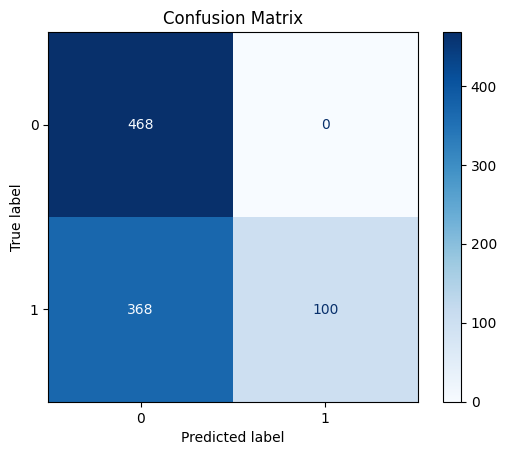

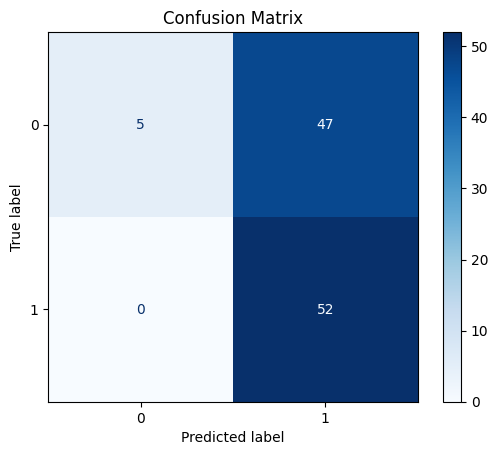

In [37]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(np.array(y_test_sem_data_augment), (y_pred_sem_data_augment >= 0.5))

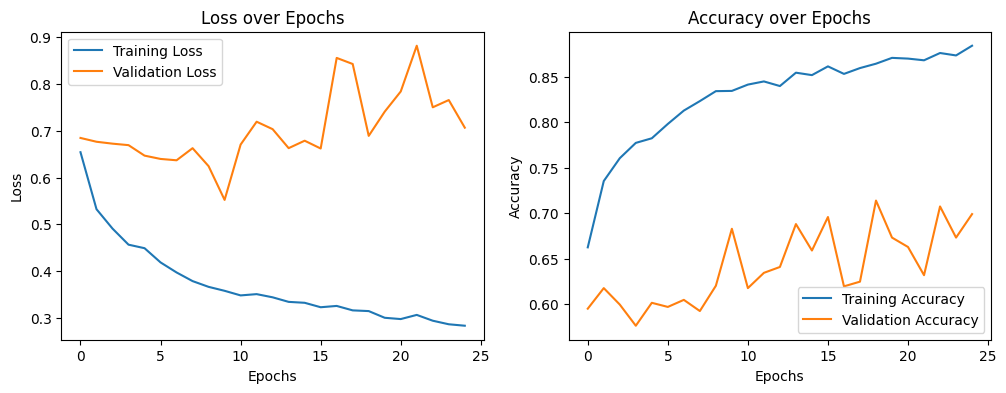

In [29]:
# Plotar o histórico do treinamento
plot_training_history(history)